## Data processing

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy.stats import chi2

# function to read the detector data in the weird format it gets saved in
def read_data(filename):
    with open(filename) as f:
        lines = f.readlines()
    vars = lines[2].strip().split("\t")
    vals = [[float(x) for x in l.split()] for l in lines[3:]]
    return pd.DataFrame(vals, columns=vars)

# read data
fr = read_data('./raw-data/arsa_4.5-4.6-0.001-baseline.txt') # fringes
nf = read_data('./raw-data/arsa_4.5-4.6-0.001-zeroed-idler.txt') # no fringes
vars = ["GT", "GR", "G'T", "G'R"]

# get uncertainties for each detection
for v in vars:
    fr[v + '_err'] = np.sqrt(fr[v])
    nf[v + '_err'] = np.sqrt(nf[v])
var_errs = [v + '_err' for v in vars]

# normalize detection counts and errors
fr[vars + var_errs] = fr[vars + var_errs].div(fr[vars].sum(axis=1), axis=0)
nf[vars + var_errs] = nf[vars + var_errs].div(nf[vars].sum(axis=1), axis=0)

# aggregate by transmitted/reflected signals
fr["T"] = fr["GT"] + fr["G'T"]
fr["R"] = fr["GR"] + fr["G'R"]
nf["T"] = nf["GT"] + nf["G'T"]
nf["R"] = nf["GR"] + nf["G'R"]

# combine uncertainties
fr["T_err"] = np.sqrt(fr["GT_err"]**2 + fr["G'T_err"]**2)
fr["R_err"] = np.sqrt(fr["GR_err"]**2 + fr["G'R_err"]**2)
nf["T_err"] = np.sqrt(nf["GT_err"]**2 + nf["G'T_err"]**2)
nf["R_err"] = np.sqrt(nf["GR_err"]**2 + nf["G'R_err"]**2)

## Raw data plots

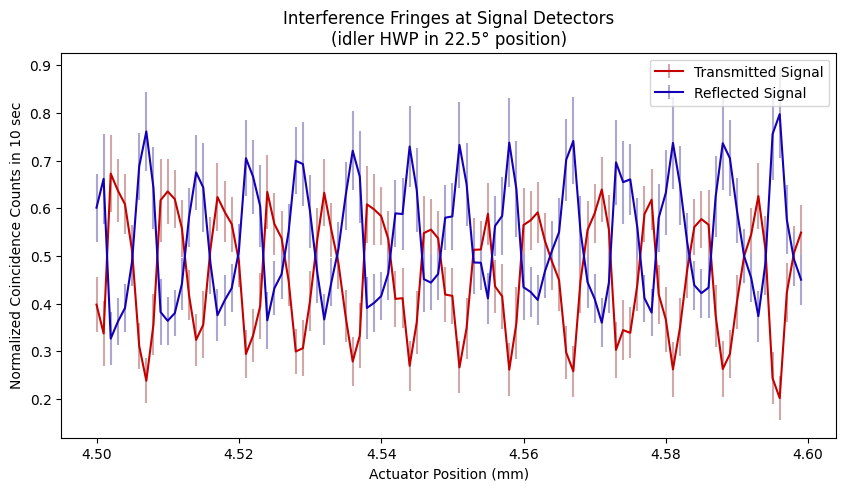

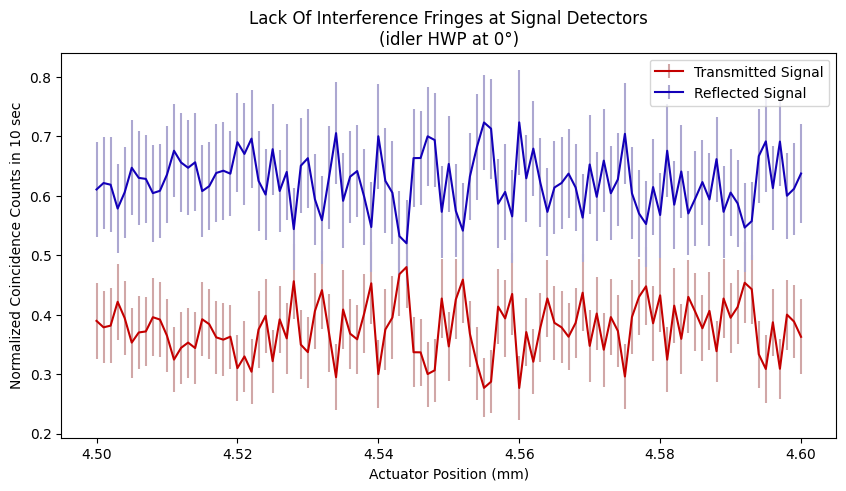

In [2]:
# COLOR setup
c_red = [196/255, 0, 0]
c_lightred = [209/255, 167/255, 167/255]
c_blue = [19/255, 0, 184/255]
c_lightblue = [172/255, 167/255, 209/255]

# setup
fig = plt.figure(figsize=(10,5))
fig.tight_layout(pad=1)

# plot fringe data
plt.errorbar(fr['position'], fr["T"], yerr=fr["T_err"], color=c_red, ecolor=c_lightred, label = "Transmitted Signal")
plt.errorbar(fr['position'], fr["R"], yerr=fr["R_err"], color=c_blue, ecolor=c_lightblue, label = "Reflected Signal")

# titles and such
plt.title('Interference Fringes at Signal Detectors\n(idler HWP in 22.5° position)')
plt.xlabel('Actuator Position (mm)')
plt.ylabel('Normalized Coincidence Counts in 10 sec')
plt.legend()

# show plot
plt.show()

# setup
fig = plt.figure(figsize=(10,5))
fig.tight_layout(pad=1)

# plot no fringe data
plt.errorbar(nf['position'], nf["T"], yerr=nf["T_err"], color=c_red, ecolor=c_lightred, label = "Transmitted Signal")
plt.errorbar(nf['position'], nf["R"], yerr=nf["R_err"], color=c_blue, ecolor=c_lightblue, label = "Reflected Signal")

# titles and such
plt.title('Lack Of Interference Fringes at Signal Detectors\n(idler HWP at 0°)')
plt.xlabel('Actuator Position (mm)')
plt.ylabel('Normalized Coincidence Counts in 10 sec')
plt.legend()

# show plot
plt.show()

## Analysis

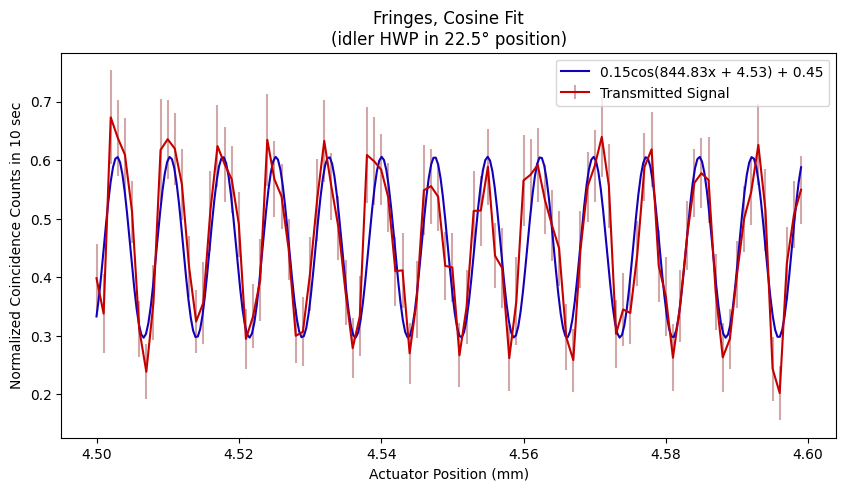

reduced chi^2 = 0.892
PTE = 0.7671137132900752


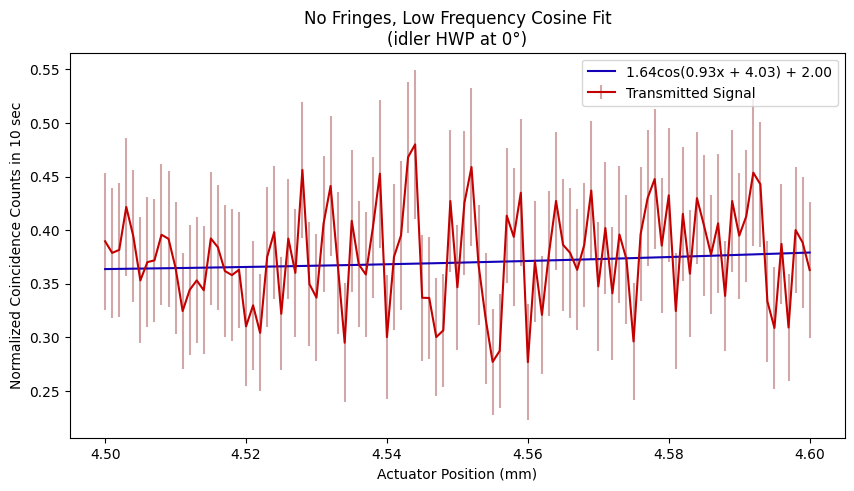

reduced chi^2 = 0.600
PTE = 0.999


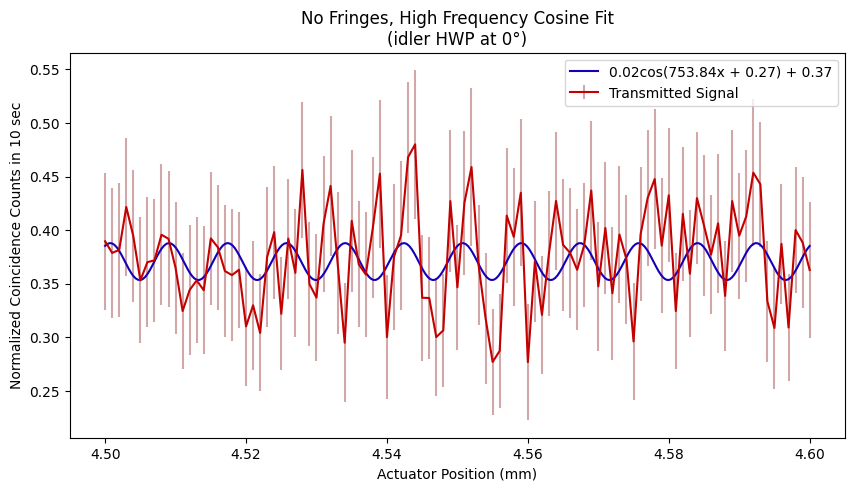

reduced chi^2 = 0.563
PTE = 1.000


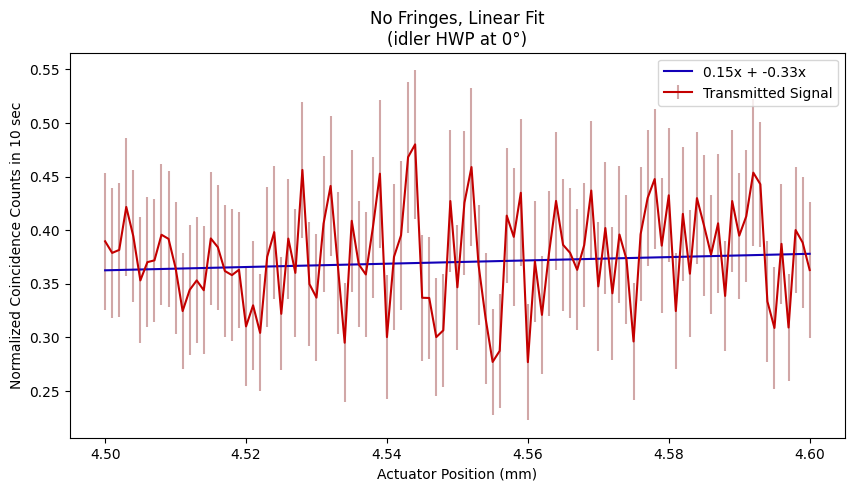

reduced chi^2 = 0.589
PTE = 1.000


In [3]:
# cosine function that will be used for all fits
def cosine(x, a, b, c, d):
    return a * np.cos(b*x + c) + d

curve_fit_bounds = np.array([[0, 0, -1, -1], [np.inf, np.inf, np.inf, 2]])

# +++ FRINGE DATA +++

# get the data out of the dataframe
ydata = fr['T'].values
yerr = fr['T_err'].values
xdata = fr['position'].values

# initial guess
p0_fr = np.array([0.18, 850, 0, 0.45], dtype=np.float64)

# fit the no-fringe data
popt, covt = opt.curve_fit(cosine, xdata, ydata, p0=p0_fr, sigma=yerr, bounds=curve_fit_bounds)
a, b, c, d = popt
c = c % (2*np.pi)

# setup
fig = plt.figure(figsize=(10,5))
fig.tight_layout(pad=1)

# plot the fit alongside fringe data
x_values = np.linspace(xdata.min(), xdata.max(), 300)
plt.errorbar(xdata, ydata, yerr=yerr, color=c_red, ecolor=c_lightred, label="Transmitted Signal")
plt.plot(x_values, cosine(x_values, *popt), color=c_blue, label = f"{a:.2f}cos({b:.2f}x + {c % 2*np.pi:.2f}) + {d:.2f}")
plt.legend()
plt.xlabel("Actuator Position (mm)")
plt.ylabel("Normalized Coincidence Counts in 10 sec")
plt.title("Fringes, Cosine Fit\n(idler HWP in 22.5° position)")
plt.show()

# get chi^2 and such
residuals = ydata - cosine(xdata, *popt)
chisq = np.sum((residuals / yerr)**2)
reduced_chisq = chisq/(len(xdata)-len(popt))
print(f'reduced chi^2 = {reduced_chisq:.3f}')
print(f'PTE = {1-chi2.cdf(chisq, len(xdata)-len(popt))}')

# +++ NO FRINGE DATA +++

# linear function to try for fitting
def linear(x, a, b):
    return a*x + b

# +++ LOW FREQUENCY COSINE FIT +++

# get the data out of the dataframe
ydata = nf['T'].values
yerr = nf['T_err'].values
xdata = nf['position'].values

# fit the no-fringe data
p0_nf = np.array([1, 1, 1, 1], dtype=np.float64)
popt, covt = opt.curve_fit(cosine, xdata, ydata, p0_nf, sigma=yerr, bounds=curve_fit_bounds)
a, b, c, d = popt
c = c % (2*np.pi)

# setup
fig = plt.figure(figsize=(10,5))
fig.tight_layout(pad=1)

# plot the fit alongside fringe data
x_values = np.linspace(xdata.min(), xdata.max(), 300)
plt.errorbar(xdata, ydata, yerr=yerr, color=c_red, ecolor=c_lightred, label="Transmitted Signal")
plt.plot(x_values, cosine(x_values, *popt), color=c_blue, label = f"{a:.2f}cos({b:.2f}x + {c % 2*np.pi:.2f}) + {d:.2f}")
plt.legend()
plt.xlabel("Actuator Position (mm)")
plt.ylabel("Normalized Coincidence Counts in 10 sec")
plt.title("No Fringes, Low Frequency Cosine Fit\n(idler HWP at 0°)")
plt.show()

# get chi^2 and such
residuals = ydata - cosine(xdata, *popt)
chisq = np.sum((residuals / yerr)**2)
reduced_chisq = chisq/(len(xdata)-len(popt))
print(f'reduced chi^2 = {reduced_chisq:.3f}')
print(f'PTE = {1-chi2.cdf(chisq, len(xdata)-len(popt)):.3f}')

# +++ HIGH FREQUENCY COSINE FIT +++

# get the data out of the dataframe
ydata = nf['T'].values
yerr = nf['T_err'].values
xdata = nf['position'].values

# fit the no-fringe data
p0_nf = np.array([0.18, 850, 0, 0.45], dtype=np.float64)
popt, covt = opt.curve_fit(cosine, xdata, ydata, p0_nf, sigma=yerr, bounds=curve_fit_bounds)
a, b, c, d = popt
c = c % (2*np.pi)

# setup
fig = plt.figure(figsize=(10,5))
fig.tight_layout(pad=1)

# plot the fit alongside fringe data
x_values = np.linspace(xdata.min(), xdata.max(), 300)
plt.errorbar(xdata, ydata, yerr=yerr, color=c_red, ecolor=c_lightred, label="Transmitted Signal")
plt.plot(x_values, cosine(x_values, *popt), color=c_blue, label = f"{a:.2f}cos({b:.2f}x + {c % 2*np.pi:.2f}) + {d:.2f}")
plt.legend()
plt.xlabel("Actuator Position (mm)")
plt.ylabel("Normalized Coincidence Counts in 10 sec")
plt.title("No Fringes, High Frequency Cosine Fit\n(idler HWP at 0°)")
plt.show()

# get chi^2 and such
residuals = ydata - cosine(xdata, *popt)
chisq = np.sum((residuals / yerr)**2)
reduced_chisq = chisq/(len(xdata)-len(popt))
print(f'reduced chi^2 = {reduced_chisq:.3f}')
print(f'PTE = {1-chi2.cdf(chisq, len(xdata)-len(popt)):.3f}')

# +++ TRY LINEAR FIT +++
popt, covt = opt.curve_fit(linear, xdata, ydata, sigma=yerr)
a, b = popt

# setup
fig = plt.figure(figsize=(10,5))
fig.tight_layout(pad=1)

# plot the fit alongside fringe data
x_values = np.linspace(xdata.min(), xdata.max(), 300)
plt.errorbar(xdata, ydata, yerr=yerr, color=c_red, ecolor=c_lightred, label="Transmitted Signal")
plt.plot(x_values, linear(x_values, *popt), color=c_blue, label = f"{a:.2f}x + {b:.2f}x")
plt.legend()
plt.xlabel("Actuator Position (mm)")
plt.ylabel("Normalized Coincidence Counts in 10 sec")
plt.title("No Fringes, Linear Fit\n(idler HWP at 0°)")
plt.show()

# get chi^2 and such
residuals = ydata - linear(xdata, *popt)
chisq = np.sum((residuals / yerr)**2)
reduced_chisq = chisq/(len(xdata)-len(popt))
print(f'reduced chi^2 = {reduced_chisq:.3f}')
print(f'PTE = {1-chi2.cdf(chisq, len(xdata)-len(popt)):.3f}')
